# maxsmi
## Analysis of results

This notebook serves to analyse the results of the simulations ran on the Curta cluster.

## Prerequisites
This notebook will run under the condition that some simulations have been run, e.g.
```
(maxsmi) $ python maxsmi/full_workflow.py --task ESOL --string-encoding smiles --aug-strategy-train augmentation_with_duplication --aug-strategy-test augmentation_with_duplication --aug-nb-train 10 --aug-nb-test 10 --ml-model CONV1D --eval-strategy True
```

Have a look at the [README](https://github.com/t-kimber/maxsmi/blob/main/README.md) page for more details.

In [1]:
#!pip install flake8 pycodestyle_magic
%load_ext pycodestyle_magic
%pycodestyle_on

In [2]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import PandasTools, rdchem
import pandas as pd
from collections import Counter

# Load results

## General results
Here we load the data which contains relevant information, such as
- total time of execution of the script: loading data, featurizing, train, and testing
- training time
- testing time
- the evolution of the loss by epoch
- MSE, RMSE, R2 on train set
- MSE, RMSE, R2 on train set

In [3]:
def load_results(task, string_encoding, augmentation_strategy_train,
                 train_augmentation, augmentation_strategy_test,
                 test_augmentation,
                 ml_model):
    with open(f"output/{task}_{string_encoding}_{augmentation_strategy_train}_"
              f"{train_augmentation}_{augmentation_strategy_test}_"
              f"{test_augmentation}_{ml_model}/"
              f"results_metrics.pkl", 'rb') as f:
        results = pickle.load(f)
        print(f"Data: \t\t\t\t {task}\n"
              f"String encoding: \t\t {string_encoding}\n"
              f"Augmentation strategy train: \t"
              f"{augmentation_strategy_train}\n"
              f"Augmentation strategy test: \t {augmentation_strategy_test}\n"
              f"Train augmentation: \t\t {train_augmentation}\n"
              f"Test augmentation: \t\t {test_augmentation}\n"
              f"Model: \t\t\t\t {ml_model}\n"
              "\n"
              f"Train R2: \t\t\t {results.train[0][2]:.3f}\n"
              f"Test R2: \t\t\t {results.test[0][2]:.3f}\n"
              f"Train RMSE: \t\t\t {results.train[0][1]:.3f}\n"
              f"Test RMSE: \t\t\t {results.test[0][1]:.3f}\n"
              "\n"
              f"Total execution time: \t\t {results.execution[0]}\n"
              f"Training time: \t\t\t {results.time_training[0]}")
        return results

In [4]:
TASK = "free_solv"
STRING_ENCODING = "smiles"
TRAIN_AUGMENTATION = 100
TEST_AUGMENTATION = 100
AUGMENTATION_STRATEGY_TRAIN = "augmentation_with_duplication"
AUGMENTATION_STRATEGY_TEST = "augmentation_with_duplication"
ML_MODEL = "CONV1D"

In [5]:
results = load_results(TASK, STRING_ENCODING, AUGMENTATION_STRATEGY_TRAIN,
                       TRAIN_AUGMENTATION, AUGMENTATION_STRATEGY_TEST,
                       TEST_AUGMENTATION,
                       ML_MODEL)
results

Data: 				 free_solv
String encoding: 		 smiles
Augmentation strategy train: 	augmentation_with_duplication
Augmentation strategy test: 	 augmentation_with_duplication
Train augmentation: 		 100
Test augmentation: 		 100
Model: 				 CONV1D

Train R2: 			 0.998
Test R2: 			 0.931
Train RMSE: 			 0.166
Test RMSE: 			 1.065

Total execution time: 		 0 days 01:08:09.772912
Training time: 			 0 days 01:07:51.780928


,execution,time_training,time_testing,loss,train,test
0,0 days 01:08:09.772912,0 days 01:07:51.780928,0 days 00:00:03.664802,"[0.3631121304242002, 0.11330045873658699, 0.07...","(0.02756677009165287, 0.16603243350982666, 0.9...","(1.1335015296936035, 1.0646603107452393, 0.930..."


In [6]:
results_df = pd.DataFrame(data=None,
                          index=["no aug.",
                                 "aug. with dupl.", "aug. without dupl.",
                                 "aug. with reduced dupl.",
                                 "aug. estimated max."],
                          columns=["CONV1D", "CONV2D", "RNN"])
results_df.index.name = "Model/aug. stategy"

In [7]:
results_df.loc["aug. with dupl.", ML_MODEL] = f"{results.test[0][2]:.3f}"
results_df

,CONV1D,CONV2D,RNN
Model/aug. stategy,,,
no aug.,NaN,NaN,NaN
aug. with dupl.,0.931,NaN,NaN
aug. without dupl.,NaN,NaN,NaN
aug. with reduced dupl.,NaN,NaN,NaN
aug. estimated max.,NaN,NaN,NaN


In [8]:
# results_latex = results_df.to_latex(buf="results_table.tex")

## Ensemble learning results
Here we load the data which contains relevant information if there was augmentation on the test set, such as
- confidence of the prediction: is the standard deviation low or high?
- the absolute error between the true value and the average value

This data represents _only_ the test set (20%) and not the full data (100%). It contains most relevant information.

In [9]:
def load_results_ensemble_learning(task, string_encoding,
                                   augmentation_strategy_train,
                                   train_augmentation,
                                   augmentation_strategy_test,
                                   test_augmentation, ml_model):
    with open(f"output/{task}_{string_encoding}_{augmentation_strategy_train}_"
              f"{train_augmentation}_{augmentation_strategy_test}_"
              f"{test_augmentation}_{ml_model}/"
              f"results_ensemble_learning.pkl", 'rb') as f:
        return pickle.load(f)

In [10]:
test_data = load_results_ensemble_learning(TASK, STRING_ENCODING,
                                           AUGMENTATION_STRATEGY_TRAIN,
                                           TRAIN_AUGMENTATION,
                                           AUGMENTATION_STRATEGY_TEST,
                                           TEST_AUGMENTATION,
                                           ML_MODEL)
test_data.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction
394,-9.40,O=C(O)c1cc(-c2ccc(F)cc2F)ccc1O,"[C(O)(c1c(ccc(-c2ccc(cc2F)F)c1)O)=O, c1(cc(-c2...","[C(O)(c1c(ccc(-c2ccc(cc2F)F)c1)O)=O, c1(cc(-c2...",-9.774343,1.380791
268,1.23,C1CCCCC1,"[C1CCCCC1, C1CCCCC1, C1CCCCC1, C1CCCCC1, C1CCC...","[C1CCCCC1, C1CCCCC1, C1CCCCC1, C1CCCCC1, C1CCC...",0.870433,0.000000
364,-9.28,CS(C)=O,"[CS(=O)C, CS(=O)C, CS(=O)C, CS(=O)C, CS(=O)C, ...","[CS(=O)C, CS(=O)C, CS(=O)C, CS(=O)C, CS(=O)C, ...",-6.454562,0.406601
612,-5.73,O=[N+]([O-])OCCO[N+](=O)[O-],"[O=[N+]([O-])OCCO[N+]([O-])=O, O=[N+]([O-])OCC...","[O=[N+]([O-])OCCO[N+]([O-])=O, O=[N+]([O-])OCC...",-5.361462,0.811861
370,0.10,ClC(Cl)=C(Cl)Cl,"[ClC(=C(Cl)Cl)Cl, ClC(=C(Cl)Cl)Cl, ClC(=C(Cl)C...","[LC(=C(L)L)L, LC(=C(L)L)L, LC(=C(L)L)L, LC(=C(...",-0.365171,0.450011


In [11]:
def get_nb_heavy_atoms(smiles):
    """
    # TODO
    """
    mol = Chem.MolFromSmiles(smiles)
    return mol.GetNumHeavyAtoms()

In [12]:
test_data["nb_heavy_atoms"] = test_data["canonical_smiles"].apply(
    get_nb_heavy_atoms)

In [13]:
def check_uniqueness(list_):
    """
    # TODO
    """
    return len(Counter(list_))

In [14]:
def len_canonical_smiles(smiles):
    """
    # TODO
    """
    return len(smiles)

In [15]:
test_data["nb_unique_smiles"] = test_data["augmented_smiles"].apply(
    check_uniqueness)

In [16]:
test_data["length_canonical_smile"] = test_data["canonical_smiles"].apply(
    len_canonical_smiles)

In [17]:
test_data.head()

,target,canonical_smiles,augmented_smiles,new_smiles,average_prediction,std_prediction,nb_heavy_atoms,nb_unique_smiles,length_canonical_smile
394,-9.40,O=C(O)c1cc(-c2ccc(F)cc2F)ccc1O,"[C(O)(c1c(ccc(-c2ccc(cc2F)F)c1)O)=O, c1(cc(-c2...","[C(O)(c1c(ccc(-c2ccc(cc2F)F)c1)O)=O, c1(cc(-c2...",-9.774343,1.380791,18,97,30
268,1.23,C1CCCCC1,"[C1CCCCC1, C1CCCCC1, C1CCCCC1, C1CCCCC1, C1CCC...","[C1CCCCC1, C1CCCCC1, C1CCCCC1, C1CCCCC1, C1CCC...",0.870433,0.000000,6,1,8
364,-9.28,CS(C)=O,"[CS(=O)C, CS(=O)C, CS(=O)C, CS(=O)C, CS(=O)C, ...","[CS(=O)C, CS(=O)C, CS(=O)C, CS(=O)C, CS(=O)C, ...",-6.454562,0.406601,4,6,7
612,-5.73,O=[N+]([O-])OCCO[N+](=O)[O-],"[O=[N+]([O-])OCCO[N+]([O-])=O, O=[N+]([O-])OCC...","[O=[N+]([O-])OCCO[N+]([O-])=O, O=[N+]([O-])OCC...",-5.361462,0.811861,10,32,28
370,0.10,ClC(Cl)=C(Cl)Cl,"[ClC(=C(Cl)Cl)Cl, ClC(=C(Cl)Cl)Cl, ClC(=C(Cl)C...","[LC(=C(L)L)L, LC(=C(L)L)L, LC(=C(L)L)L, LC(=C(...",-0.365171,0.450011,6,5,15


# Some statistics

### Distribution of the target

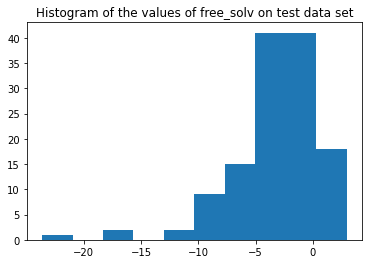

Minimum value: -23.62
Minimum value: 2.93


In [18]:
fig, ax = plt.subplots()
plt.hist(test_data['target'])
ax.set_title(f"Histogram of the values of {TASK} on test data set")
plt.show()
print(f"Minimum value: {test_data['target'].min()}")
print(f"Minimum value: {test_data['target'].max()}")

### Range of standard deviation of prediction

In [19]:
print(f"Minimum: {test_data['std_prediction'].min():.2f} \t \t "
      f"associated index: {test_data['std_prediction'].idxmin()}")

Minimum: 0.00 	 	 associated index: 268


In [20]:
print(f"Maximum: {test_data['std_prediction'].max():.2f} \t \t "
      f"associated index: {test_data['std_prediction'].idxmax()}")

Maximum: 2.82 	 	 associated index: 544


### Visualize the molecules

In [21]:
def ensemble_learning_metric(metric="min", num=3,
                             augmentation_strategy=AUGMENTATION_STRATEGY_TEST):
    """
    Return the rdkit molecule object with `metric` standard deviation.

    Parameters
    ----------
    metric : str
        The metric to consider for the standard deviation of the prediction.
    num : int
        The top n `num` entries to consider.

    Returns
    -------
    tuple
        target, canonical SMILES, random SMILES, RDKit molecule.
    """

    print("Augmentation strategy: ", augmentation_strategy)
    print("\n")
    if metric == "min":
        selection = test_data.nsmallest(num, 'std_prediction', keep="all")
    if metric == "max":
        selection = test_data.nlargest(num, 'std_prediction', keep="all")

    for index in selection.index:
        canonical_smile = test_data.loc[index]["canonical_smiles"]
        mol = Chem.MolFromSmiles(canonical_smile)
        print("Canonical SMILES: ",  canonical_smile)
        random_smiles = test_data.loc[index]["augmented_smiles"]
        target = test_data.loc[index]["target"]
        print(f"True value: {target:.2f}")
        average_prediction = test_data.loc[index]['average_prediction']
        print(f"Average prediction: {average_prediction:.2f}")
        absolute_error = np.absolute(
            test_data.loc[index]["target"] -
            test_data.loc[index]["average_prediction"]
        )
        print(f"Absolute of the averaged error: {absolute_error:.2f}")
        selection.loc[index,
                      "absolute_average_error"] = absolute_error

        standard_deviation_prediction = test_data.loc[index,
                                                      "std_prediction"]
        print(f"Standard deviation in prediction: "
              f"{standard_deviation_prediction}")
        # print(standard_deviation_prediction == 0)

        # print(mol)
        print("\n")
        PandasTools.AddMoleculeColumnToFrame(selection,
                                             smilesCol='canonical_smiles')
    return selection

In [22]:
# high_confidence_mol = ensemble_learning_metric("min")
# high_confidence_mol[["target", "average_prediction",
#                     "absolute_average_error",
#                      "std_prediction", "canonical_smiles", "ROMol"]]

Augmentation strategy:  augmentation_with_duplication


Canonical SMILES:  ClC1=C(Cl)[C@]2(Cl)[C@H]3[C@H]4C[C@H]([C@@H]5O[C@@H]54)[C@H]3[C@@]1(Cl)C2(Cl)Cl
True value: -4.82
Average prediction: -5.25
Absolute of the averaged error: 0.43
Standard deviation in prediction: 2.818488836288452


Canonical SMILES:  Cn1c(=O)c2c(ncn2C)n(C)c1=O
True value: -12.64
Average prediction: -12.50
Absolute of the averaged error: 0.14
Standard deviation in prediction: 1.8089914321899414


Canonical SMILES:  OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
True value: -23.62
Average prediction: -23.52
Absolute of the averaged error: 0.10
Standard deviation in prediction: 1.4194402694702148




,target,average_prediction,absolute_average_error,std_prediction,canonical_smiles,ROMol
544,-4.82,-5.246411,0.426411,2.818489,ClC1=C(Cl)[C@]2(Cl)[C@H]3[C@H]4C[C@H]([C@@H]5O...,
121,-12.64,-12.498579,0.141421,1.808991,Cn1c(=O)c2c(ncn2C)n(C)c1=O,
44,-23.62,-23.521292,0.098708,1.419440,OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO,

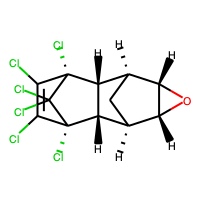
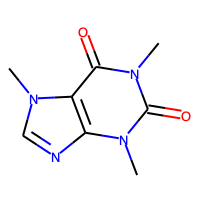
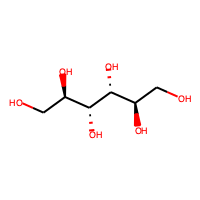

In [23]:
low_confidence_mol = ensemble_learning_metric("max")
low_confidence_mol[["target", "average_prediction", "absolute_average_error",
                    "std_prediction", "canonical_smiles", "ROMol"]]

In [24]:
large_molecules = ensemble_learning_metric("max")

Augmentation strategy:  augmentation_with_duplication


Canonical SMILES:  ClC1=C(Cl)[C@]2(Cl)[C@H]3[C@H]4C[C@H]([C@@H]5O[C@@H]54)[C@H]3[C@@]1(Cl)C2(Cl)Cl
True value: -4.82
Average prediction: -5.25
Absolute of the averaged error: 0.43
Standard deviation in prediction: 2.818488836288452


Canonical SMILES:  Cn1c(=O)c2c(ncn2C)n(C)c1=O
True value: -12.64
Average prediction: -12.50
Absolute of the averaged error: 0.14
Standard deviation in prediction: 1.8089914321899414


Canonical SMILES:  OC[C@@H](O)[C@@H](O)[C@H](O)[C@H](O)CO
True value: -23.62
Average prediction: -23.52
Absolute of the averaged error: 0.10
Standard deviation in prediction: 1.4194402694702148




In [25]:
total_min = min(test_data['target'].min(),
                test_data['average_prediction'].min())
total_max = max(test_data['target'].max(),
                test_data['average_prediction'].max())

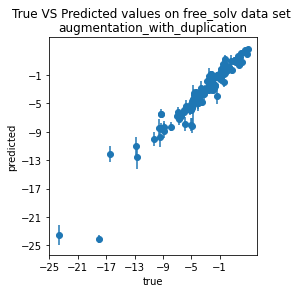

In [26]:
fig, ax = plt.subplots()
x = test_data["target"]
y = test_data["average_prediction"]
err = test_data["std_prediction"]

plt.errorbar(x, y, yerr=err, fmt='o')

ax.set_xticks(np.arange(np.floor(total_min), np.ceil(total_max), 4))
ax.set_yticks(np.arange(np.floor(total_min), np.ceil(total_max), 4))
ax.set_xlabel("true")
ax.set_ylabel("predicted")
ax.set_aspect("equal", adjustable="box")
ax.set_title(f"True VS Predicted values on {TASK} data set \n"
             f"{AUGMENTATION_STRATEGY_TEST}")

plt.show()

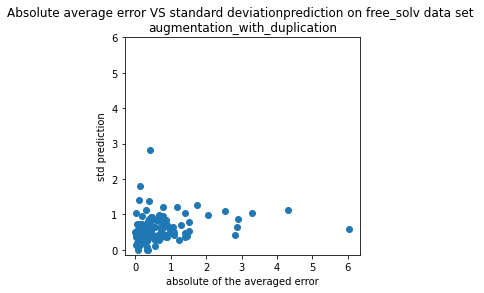

In [27]:
fig, ax = plt.subplots()
x = np.absolute(test_data["target"].values -
                test_data["average_prediction"].values)
y = test_data["std_prediction"].values

total_min = min(min(x), min(y))
total_max = max(max(x), max(y))
plt.scatter(x, y)

ax.set_xticks(np.arange(np.floor(total_min), np.ceil(total_max), 1))
ax.set_yticks(np.arange(np.floor(total_min), np.ceil(total_max), 1))
ax.set_xlabel("absolute of the averaged error")
ax.set_ylabel("std prediction")
ax.set_aspect("equal", adjustable="box")
ax.set_title(f"Absolute average error VS standard deviation"
             f"prediction on {TASK} data set \n"
             f"{AUGMENTATION_STRATEGY_TEST}")

plt.show()

In [28]:
def ensemble_large(num=10):
    selection = test_data.nlargest(num, 'nb_heavy_atoms', keep="all")

    for index in selection.index:
        canonical_smile = test_data.loc[index]["canonical_smiles"]
        mol = Chem.MolFromSmiles(canonical_smile)
        print("Canonical SMILES: ",  canonical_smile)
        random_smiles = test_data.loc[index]["augmented_smiles"]
        target = test_data.loc[index]["target"]
        print(f"True value: {target:.2f}")
        average_prediction = test_data.loc[index]['average_prediction']
        print(f"Average prediction: {average_prediction:.2f}")
        absolute_error = np.absolute(
            test_data.loc[index]["target"] -
            test_data.loc[index]["average_prediction"]
        )
        print(f"Absolute of the averaged error: {absolute_error:.2f}")
        selection.loc[index,
                      "absolute_average_error"] = absolute_error

        standard_deviation_prediction = test_data.loc[index,
                                                      "std_prediction"]
        print(f"Standard deviation in prediction: "
              f"{standard_deviation_prediction}")
        # print(standard_deviation_prediction == 0)

        # print(mol)
        print("\n")
        PandasTools.AddMoleculeColumnToFrame(selection,
                                             smilesCol='canonical_smiles')
    return selection

In [29]:
n_largest_mol = ensemble_large(15)

Canonical SMILES:  CCCN(CCC)c1c([N+](=O)[O-])cc(C(F)(F)F)cc1[N+](=O)[O-]
True value: -3.25
Average prediction: -3.68
Absolute of the averaged error: 0.43
Standard deviation in prediction: 0.7925751805305481


Canonical SMILES:  Clc1cc(-c2c(Cl)cc(Cl)c(Cl)c2Cl)c(Cl)c(Cl)c1Cl
True value: -4.61
Average prediction: -3.52
Absolute of the averaged error: 1.09
Standard deviation in prediction: 0.5077185034751892


Canonical SMILES:  Clc1ccc(-c2cc(Cl)c(Cl)c(Cl)c2Cl)c(Cl)c1Cl
True value: -4.40
Average prediction: -3.42
Absolute of the averaged error: 0.98
Standard deviation in prediction: 0.47880569100379944


Canonical SMILES:  ClC1=C(Cl)[C@]2(Cl)[C@H]3[C@H]4C[C@H]([C@@H]5O[C@@H]54)[C@H]3[C@@]1(Cl)C2(Cl)Cl
True value: -4.82
Average prediction: -5.25
Absolute of the averaged error: 0.43
Standard deviation in prediction: 2.818488836288452


Canonical SMILES:  Clc1ccc2c(c1)Oc1c(Cl)c(Cl)c(Cl)c(Cl)c1O2
True value: -4.15
Average prediction: -4.44
Absolute of the averaged error: 0.29
Standard deviatio

,ROMol,std_prediction,nb_unique_smiles
126,,0.427290,68
606,,0.456535,65
226,,0.478806,99
169,,0.506318,100
458,,0.507719,100
62,,0.564514,34
344,,0.649834,34
21,,0.729590,77
495,,0.792575,92
444,,0.933511,73

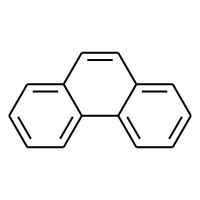
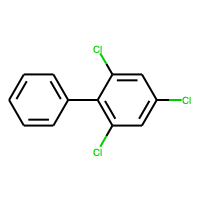
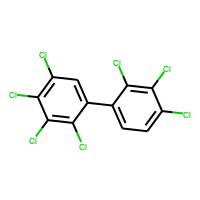
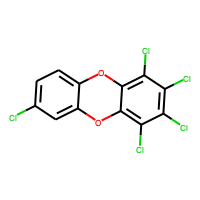
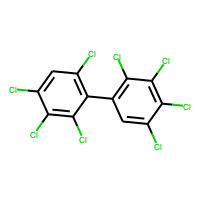
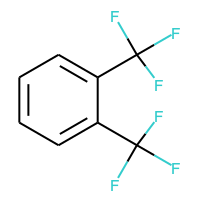
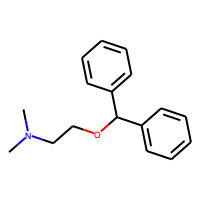
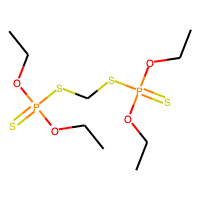
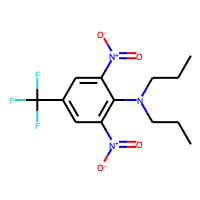
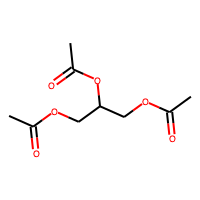
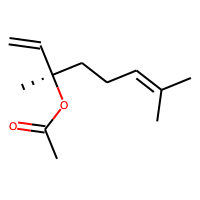
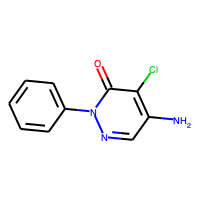
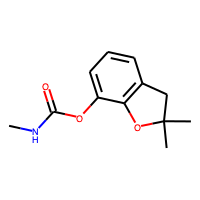
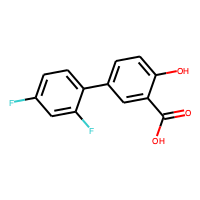
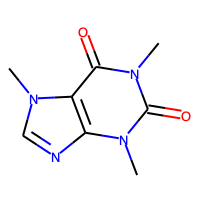
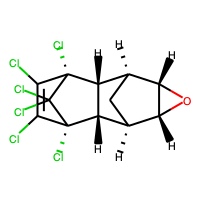

In [30]:
n_largest_mol = n_largest_mol[["ROMol", "std_prediction", "nb_unique_smiles"]]
n_largest_mol = n_largest_mol.sort_values(by=["std_prediction"])
n_largest_mol